# Membrane-only systems

**Last executed:** Sep 21, 2021 with MDAnalysis 2.1.0b



**Packages required:** MDAnalysis.


**Packages for visualization:** Matplotlib, SciPy.

In this tutorial, we are going to use MembraneCurvature to derive surfaces and calculate curvature of a lipid bilayer of lipid composition POPC:POPE:CHOL and a 5:4:1 ratio from a Molecular Dynamics (MD) simulation carried out using the [Martini](http://cgmartini.nl/) force field.

In [1]:
import MDAnalysis as mda
from membrane_curvature.base import MembraneCurvature
from membrane_curvature.tests.datafiles import MEMB_GRO, MEMB_XTC
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

MDAnalysis  : INFO     MDAnalysis 2.1.0-dev0 STARTED logging to 'MDAnalysis.log'


Because the system included in this tutorial uses the [Martini](http://cgmartini.nl/) coarse grain representation, we prefer to suppress the warnings from MDAnalysis. Please note that this shouldn't be the standard approach for your code as warnings may give you some heads-up about issues with your system. 

In [2]:
import warnings
warnings.filterwarnings('ignore')

---

For a better understanding of how MembraneCurvature help us to calculate membrane curvature, let's split the process into five main steps:

[1. Load MDA Universe](#1.-Load-MDA-Universe)

[2. Select Atoms of Reference](#2.-Select-Atoms-of-Reference)

[3. Run MembraneCurvature](#3.-Run-MembraneCurvature)

[4. Extract Results](#4.-Extract-Results)

[5. Visualize Results](#5.-Visualize-Results)

---


## 1. Load MDA Universe

We start by loading our molecular dynamics output files (coordinates and trajectory) into an MDAnalysis Universe: 

In [3]:
universe = mda.Universe(MEMB_GRO, MEMB_XTC)

A quick check of our Universe gives us a better idea of the system used in this tutorial. To check the dimensions of the simulation box, number of lipid residues, total number of beads, as well as the number of frames in the trajectory contained in our Universe, we can run: 

In [4]:
print("Universe info:")
print("\nBox dimensions[x,y,z]: {}." \
      "".format(universe.dimensions[:3]))

print("\n{} lipid residues and {} beads." \
      "".format(universe.residues.n_residues, universe.residues.n_atoms))

print("\nLipid types: ")
[print("-"+lipid) for lipid in set(universe.residues.resnames)]

print("\nThe trajectory includes {} frames."\
      "".format(universe.trajectory.n_frames))

Universe info:

Box dimensions[x,y,z]: [241.12502 241.12502 233.69261].

2046 lipid residues and 23736 beads.

Lipid types: 
-POPC
-POPE
-CHOL

The trajectory includes 11 frames.


It probably gets easier if we can have a quick visual inspection of the system. To visualize our system, we can make use of the [NGL Viewer](https://github.com/nglviewer/nglview).

In [5]:
import nglview as nv

def color_by_resname(system, zoom, color_, box=False):

    
    view = nv.show_mdanalysis(system)
    view.add_representation('ball+stick', selection='not CHOL', radius=0.5, color="grey")
    view.add_representation('ball+stick', selection='.PO4', radius=2.00, color=color_)
    view.add_representation('ball+stick', selection='not POPC and not POPE', radius=0.5, color="yellow")
    view.add_representation('ball+stick', selection='.ROH', radius=2.00, color="orange")
    
    if box == True:
        view.add_unitcell()
    
    view.camera='orthographic'
    view.control.zoom(zoom)
    view.control.rotate(
         mda.lib.transformations.quaternion_from_euler(
             -np.pi/2, np.pi/3, np.pi/12, 'rzyz').tolist())
    
    
    return view

In [6]:
color_by_resname(universe, 0.5, "brown")

NGLWidget(max_frame=10)

The NGL Viewer enables us to identify two main types of lipids: phospholipids, POPC and POPE lipids, shown in grey colour; and sterols, CHOL lipids, shown in yellow. All phospholipid head groups are shown in red, and sterol head groups are shown in orange.

Since membraneCurvature uses the dimensions of the box to set the dimensions of the grid (See [Algorithm](https://membrane-curvature.readthedocs.io/en/latest/source/pages/Algorithm.html#set-grid)), it is important to run a preliminary check to confirm that our system does not display significant box size fluctuations over time.  

We can quickly check the fluctuations of our simulation box for the `x` and `y` dimensions with:

In [7]:
for ts in universe.trajectory:
    print(ts.frame, ts.dimensions[:2])

0 [241.12502 241.12502]
1 [241.33353 241.33353]
2 [240.43678 240.43678]
3 [240.13823 240.13823]
4 [240.14366 240.14366]
5 [240.20067 240.20067]
6 [239.7728 239.7728]
7 [240.65321 240.65321]
8 [239.9748 239.9748]
9 [240.36978 240.36978]
10 [240.5304 240.5304]


With a fluctuation of $~1\%$ in each dimension, we know that the grid set by MembraneCurvature using the `u.dimensions` will contain all the elements in our system.


Now that we have a better idea of what the system used in this tutorial contains and we have verified the fluctuations of the box are not significant, we can go to step 2 and select our atoms of reference.

## 2. Select Atoms of Reference

The [MembraneCurvature algorithm](https://membrane-curvature.readthedocs.io/en/latest/source/pages/Algorithm.html) uses an `AtomGroup` as a reference to derive surfaces. Therefore, it's important to identify what constitutes a sensible selection for an `AtomGroup` of reference. Keep in mind that choosing atoms that display flip-flop during your simulation is not a good idea. The atoms in your `AtomGroup` of reference should remain in the same leaflet over the simulation time.

Typically in lipid bilayers, phospholipid headgroups are the most straightforward `AtomGroup` from which to derive surfaces. In this tutorial, we are going to choose phospholipid headgroups of phosphate beads. In the Martini representation, these beads are called `PO4`. Then, we can select the phospholipid head groups (`PO4` beads) in our Universe with:

In [8]:
PO4_headgroups = universe.select_atoms('name PO4')

<div class="alert alert-block alert-info">
<b>**NOTE:**</b> <br>
In contrast to sterols, phospholipids molecules have a very slow flip-flop rate. As a general approach, phospholipid head groups are a better choice than sterol headgroups. 
Hence, our `AtomGroup` does not include cholesterol headgroups (`ROH` beads) and uses `PO4` beads instead.    
</div>

The atoms selected in `PO4_headgroups` include the whole membrane instead of the individual leaflets within which the `PO4_headgroups` reside. Since MembraneCurvature calculates curvature from a single surface, we should select an `AtomGroup` for each leaflet.


To select leaflets we have two options:



[2.1 Direct parsing](#2.1-Direct-parsing) 

[2.2 Leaflet identification](#2.2-Leaflet-identification)

### 2.1 Direct parsing

If we know which atoms or beads belong to each leaflet, we can directly parse the selection. It is recommended to check that your selection is correct before running MembraneCurvature. 

In this tutorial, we are working with a lipid bilayer that can be split into the upper and the lower leaflet based on their residue number and the name of the head group. We know that we have 1023 residues per leaflet, and since we are going to derive surfaces based on this selection, we also choose the lipid headgroups.  

So we can select our leaflets with:


In [9]:
upper_leaflet = universe.select_atoms('resid 0-1023 and name PO4')
print('We have {} beads in the upper leaflet'.format(len(upper_leaflet)))

lower_leaflet = universe.select_atoms('resid 1024-2046 and name PO4') 
print('and {} beads in the upper leaflet'.format(len(lower_leaflet)))

We have 921 beads in the upper leaflet
and 921 beads in the upper leaflet


To double-check that the variables `lower_leaflet ` and `upper leaflet` contain atoms from different leaflets, we write a function using [NGL Viewer](https://github.com/nglviewer/nglview) to visualize the `AtomGroup` for each leaflet according to the selection above. 



In [10]:
def color_by_leaflet(system, zoom, box=False):

    
    view = nv.show_mdanalysis(system)
    view.add_representation('ball+stick', selection='0-1023 and .PO4', radius=2.00, color="steelblue")
    view.add_representation('ball+stick', selection='1024-2046 and .PO4', radius=2.00, color="darkcyan")

    if box == True:
        view.add_unitcell()
    
    view.camera='orthographic'
    view.control.zoom(zoom)
    view.control.rotate(
         mda.lib.transformations.quaternion_from_euler(
             -np.pi/2, np.pi/3, np.pi/12, 'rzyz').tolist())
    
    
    return view

color_by_leaflet(universe, 0.5)


NGLWidget(max_frame=10)

From the NGL widget we can identify two leaflets. The upper leaflet, coloured in blue, with residues 1-1023; and the lower leaflet, coloured in cyan, with residues 1024-2046.

### 2.2 Leaflet identification

We can automatically identify lipids by leaflet using the [leaflet MDAnalysis module](https://docs.mdanalysis.org/2.0.0-dev0/documentation_pages/analysis/leaflet.html). This option may be very helpful when we don't know the details of our system and we need to identify the residues in each leaflet of the bilayer.

To identify leaflets using the MDAnlysis LeafletsFinder analysis module we do: 

In [11]:
from MDAnalysis.analysis.leaflet import LeafletFinder

L = LeafletFinder(universe, 'name PO4')

up_leaflet = L.groups(0) # upper leaflet
low_leaflet = L.groups(1) # lower leafet

Here, the variables `up_leaflet` and `low_leaflet` are `AtomGroups`. 

These selections are equivalent to the previous ones stored in the variables `upper_leaflet` and `lower_leaflet`. A quick visualization of the selections obtained by `LeafletFinder` can help us to check that our selections are the same:

In [12]:
color_by_leaflet(up_leaflet + low_leaflet, 0.5)

NGLWidget(max_frame=10)

To check that each one of the leaflets obtained with `LeafletFinder` have an identical selection and has the same number of elements, we can print the residue numbers and length:

In [13]:
leaflets = ["Lower", "Upper"]

list_new_leaflets = [up_leaflet.residues.resids, 
                     low_leaflet.residues.resids]

for name, new_lf in zip(leaflets,list_new_leaflets):
    print("{} leaflet includes resid {}-{} "  \
          "and a total of {} elements.".format(name,
                                               new_lf[0], 
                                               new_lf[-1], 
                                               len(new_lf)))


Lower leaflet includes resid 103-1023 and a total of 921 elements.
Upper leaflet includes resid 1126-2046 and a total of 921 elements.


Now that we know how to select our `AtomGroup` of reference, we can run MembraneCurvature.

## 3. Run MembraneCurvature

`MembraneCurvature` is a Python class that performs multiframe analyses to derive surfaces from the `AtomGroup` of reference. From the derived surface, `MembraneCurvature` calculates mean and Gaussian curvature per frame, and their respective average over frames.

```
MembraneCurvature(universe,          # universe
                  select='name PO4', # selection of reference
                  n_x_bins=12,       # number of bins in the x dimension
                  n_y_bins=12,       # number of bins in the y_dimension
                  wrap=True)         # wrap coordinates to keep atoms in the main unit cell
```

To use MembraneCurvature, we have four main parameters to provide:

* **Universe**: The Universe that contains our system of interest. In this tutorial, our Universe comprises a membrane of POPC POPE CHOL lipids, as described in [Section 1](#1.-Load-MDA-Universe).

* **Atom selection** (`select`): This is a key parameter to run MembraneCurvature. Based on this selection, surfaces will be derived for every frame in the trajectory. Simultaneously, curvature will be calculated from the derived surface. In this tutorial, we selected each one of the leaflets in our Universe as shown in [2. Select Atoms of Reference](#2.-Select-Atoms-of-Reference).

- **Number of bins** (`n_x_bins`, `n_y_bins`): Choosing the number of bins is also important. Choosing too many bins may introduce undefined values in the grid built by the MembraneCurvature algorithm. On the other hand, a very low number of bins may result in significant loss of information. We recommend taking bins of size ~2A. In [Section 1](#1.-Load-MDA-Universe) we found that our Universe has dimensions ~240 x 240 Å. Therefore, in this tutorial we are going to use `n_x_bins=n_y_bins=12`.

- **Coordinate wrapping** (`wrap`): Applying coordinate wrapping is useful when we have atoms in our simulation box falling outside the boundaries of the simulation box. Since this is a raw trajectory, and we want to have a high number of lipid headgroups to derive the surface, we use `wrap=True` to put all the atoms in the primary unit cell. 





Now that we have have the `AtomGroup` associated to each leaflet, and we know what parameters are needed, we can run MembraneCurvature. To run MembraneCurvature on the upper leaflet we do:


In [14]:
curvature_upper_leaflet = MembraneCurvature(universe, 
                                            select="resid 103-1023 and name PO4", 
                                            n_x_bins=12, 
                                            n_y_bins=12, 
                                            wrap=True).run()

MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up


Similarly, for the lower leaflet, we run MembraneCuvature with:

In [15]:
curvature_lower_leaflet = MembraneCurvature(universe, 
                                            select='resid 1024-2046 and name PO4', 
                                            n_x_bins=12, 
                                            n_y_bins=12, 
                                            wrap=True).run()

MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up


---

**Note:** <br>
The default MDAnalysis `.run()` includes all the trajectory frames included in the Universe. To calculate membrane curvature in specific frames, you can pass specific frames or steps by calling run using the `start`, `stop`, `step` parameters.

For example, to calculate curvature in the upper leaflet for the 4th and 7th frame, we run:

In [16]:
 curv_upper_leaflet_f47 = MembraneCurvature(universe, 
                                            select='resid 1-1023 and name PO4', 
                                            n_x_bins=12, 
                                            n_y_bins=12, 
                                            wrap=True).run(start=4, stop=8, step=3)


MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up


---

## 4. Extract Results

`MembraneCurvature` stores the calculation of surface and curvature in the `.results` attribute. We can find two different types of results: 

* **Multiframe** <br>
We can extract the data from MembraneCurvature for all the frames in the trajectory. These results are available for surface, mean and Gaussian curvature. 
 
```
curvature_upper_leaflet.results.z_surface
curvature_upper_leaflet.results.mean_curvature
curvature_upper_leaflet.results.gaussian_curvature
```

* **Average over frames** <br>
We extract values of surface, mean and Gaussian curvature averaged over the `n_frames` of the trajectory.

```
curvature_upper_leaflet.results.average_z_surface
curvature_upper_leaflet.results.average_mean
curvature_upper_leaflet.results.average_gaussian
```

In this section, we are going to extract the results for surface, mean and Gaussian curvature. However, to illustrate the two types of results you can obtaine with MembraneCurvature, the example of the derived surface will use the **Multiframe** result, and for curvature we will show results when it is **averaged over frames**. 

### 4.1 Surface

As we mentioned before, the array containing the derived surface for each frame in the trajectory can be found in the `results` attribute. 

We can check the surface derived from the lipid headgroups in the upper leaflet with:

In [17]:
surface_upper_leaflet = curvature_upper_leaflet.results.z_surface

It's important to note that `surface_upper_leaflet` is an array of shape (`n_frames`, `n_x_bins`, `n_y_bins`).

We can check the shape of the results for surface doing:

In [18]:
surface_upper_leaflet.shape

(11, 12, 12)

This shape indicates that we have 11 frames in our trajectory, and for each frame we have a surface derived from our `AtomGroup`. It also indicates that the dimensions of our simulation box was divided into 12 bins.

Similarly, for the lower leaflet we run:

In [19]:
surface_lower_leaflet = curvature_lower_leaflet.results.z_surface

Now that we know how to extract the calculated surface and curvature values, the final step is to visualize the results. To visualize **multiframe** results, go to [visualizing multiframe results](#Visualizing-multiframe-results).

### 4.2 Curvature

The resulting curvature values are stored in the attributes `.results.average_mean_curvature` and
`results.average_gaussian_curvature`. 


These arrays contain the computed values of mean ($H$) and Gaussian ($K$) curvature averaged over the `n_frames` of the trajectory.

#### Mean Curvature ($H$)

We can save the calculated values of membrane curvature for each leaflet in two new variables called `mean_upper_leaflet` and `mean_lower_leaflet`: 

In [20]:
mean_upper_leaflet = curvature_upper_leaflet.results.average_mean

mean_lower_leaflet = curvature_lower_leaflet.results.average_mean

In this case, since we are extracting the results of averaged mean curvature, the shape of these arrays is simply `(n_x_bins, n_y_bins)`:

In [21]:
mean_upper_leaflet.shape

(12, 12)

#### Gaussian Curvature ($K$)

Since the information of the averaged Gaussian curvature is stored in the `results.average_gaussian` attribute, we can store the values of $K$ in another two variables `gaussian_upper_leaflet` and `gaussian_lower_leaflet`:

In [22]:
gaussian_upper_leaflet = curvature_upper_leaflet.results.average_gaussian

In [23]:
gaussian_lower_leaflet = curvature_lower_leaflet.results.average_gaussian

Now that we have extracted the data containing values of surface, mean and Gaussian curvature, we can proceed to [visualize the results](#5.-Visualize-Results).


**Note:** <br>
Running MembraneCurvature analysis iterates over the trajectory provided in the Universe. In this particular example, our Universe has 11 frames. By running MembraneCurvature from a static file (i.e. coordinates file only with no trajectory), the data stored in the **average over frames** results (`results.average_z_surface`, `results.average_mean`, and `results.average_gaussian`) will be the same as the **Multiframe** results (`results.z_surface`, `results.mean`, `results.gaussian`).


## 5. Visualize Results

There are two main approaches to visualize results from MembraneCurvature.

[Contours](#Contours)

[Imshow](#Imshow)


### Contours

To visualize the results obtained from the MembraneCurvature we can use [contourf](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html) from [Matplotlib](https://matplotlib.org/stable/index.html). By using `contourf` to plot MembraneCurvature results, we gather all the points of equal value and the region enclosed by that set of points is coloured according to a colormap of preference.

To illustrate the most basic plot we can generate using contours, we are going to plot the averaged mean curvature obtained for the upper leaflet. We do:

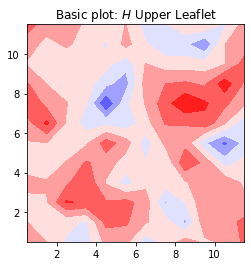

In [24]:
fig, ax = plt.subplots(1,1)
ax.contourf(mean_upper_leaflet, cmap='bwr', origin='lower', linewidth=0.1)
ax.set_aspect('equal')
ax.set_title('Basic plot: $H$ Upper Leaflet')
plt.show()

In this basic plot of mean curvature, there are several rough edges in the contours, and it lacks a colorbar for reference.

A more elaborate way to plot contours uses the [zoom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html#scipy.ndimage.zoom) function from the [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html) package for multidimensional processing. With the `zoom` option, we smooth the contours.

Hence, a smooth contour plot of mean curvature with its respective color bar can be generated with the function `plot_contours` as follows: 

In [25]:
from scipy import ndimage

def plot_contours(results, label, levels_, cm):
    """
    MembraneCurvature is a tool to calculate membrane curvature.

    Parameters
    ----------
    results: list
        List with results by leaflets as elements [lower_leaflet, upper_leaflet]
    label: str
        Label to add to colorbar. 
    levels: int
        Determines number of contour lines.
    cmap: str
        Colormap to use in plot.
    
    """
    
    fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(4,3.5), dpi=200)
    max_ = np.max(abs(results[0]))
    for ax, rs, lf in zip((ax1, ax2), results, leaflets):
        rs = ndimage.zoom(rs, 3, mode='wrap', order=2)
        if np.min(rs) < 0 < np.max(rs):
            levs = np.linspace(-max_, max_, levels_)
            im = ax.contourf(rs, cmap=cm, origin='lower', levels=levs, alpha=0.95, vmin=-max_, vmax=max_)
            tcs = [-max_, 0, max_]
        else:
            levs = np.linspace(int(np.min(rs)), round(np.max(rs)), levels_)
            im = ax.contourf(rs, cmap=cm, origin='lower', levels=levs, alpha=0.95,  vmin=int(np.min(rs)), vmax=round(np.max(rs)))
            tcs = [int(np.min(rs)), round(np.max(rs))]
            
        ax.set_aspect('equal')
        ax.set_title('{} Leaflet'.format(lf), fontsize=6)
        ax.axis('off')
        cbar = plt.colorbar(im, ticks=tcs, orientation='horizontal', ax=ax, shrink=0.7, aspect=10, pad=0.05)
        cbar.ax.tick_params(labelsize=4, width=0.5)
        cbar.set_label(label, fontsize=6, labelpad=2) 
    return

Note that there are three arguments in the `plot_contours` function. The first one is a list that contains the results of curvature by leaflet, the second one is the label to attach to the colorbar, the third one is the number of levels (see [contourf](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html) documentation), and the fourth one is the colormap to use in the plot.

Then, to make use of `plot_contours`, we also need to define a list of the results by leaflet, as well as the name of each leaflet:

In [26]:
mean_curvs = [mean_lower_leaflet, mean_upper_leaflet]

We can generate a more elaborated `contour` plots for mean curvature with:

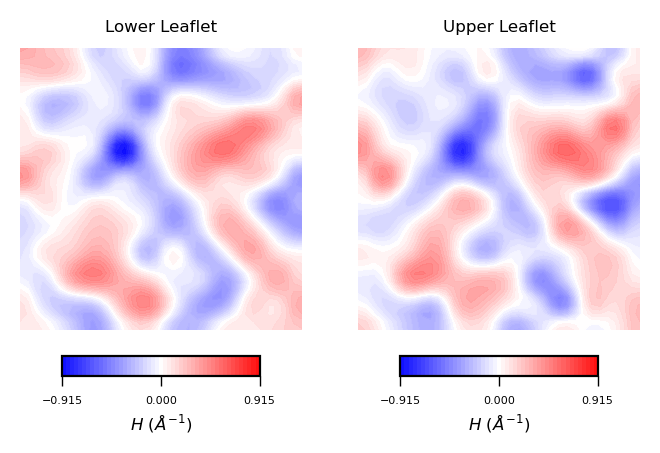

In [27]:
plot_contours(mean_curvs, "$H$ ($\AA^{-1}$)", 50, "bwr")

Interpreting mean curvature plots is straightforward. Mean curvature ($H$) gives information about the "inverted shape" of the surface. Positive mean curvature indicates valleys (red coloured), negative mean curvature indicates peaks (blue coloured). 

Hence, from the obtained contour plot of mean curvature we can identify:

* Coupling between leaflets. Regions of positive curvature (red coloured) in the lower leaflet match those in the upper leaflet. The same is observed for regions of negative mean curvature (blue coloured).

* A central region of negative mean curvature. For both upper and lower leaflet, there is a central region of negative mean curvature (blue coloured) along the `y` axis, while regions of positive mean curvature (red coloured) are localized at the corners of the membrane, in particular bottom left and upper right corners.


Similar to the approach used for mean curvature, to plot the results of averaged Gaussian curvature we first create the list of curvatures:

In [28]:
gaussian_curvs = [gaussian_lower_leaflet, gaussian_upper_leaflet]

And then call the `plot_contours` function:

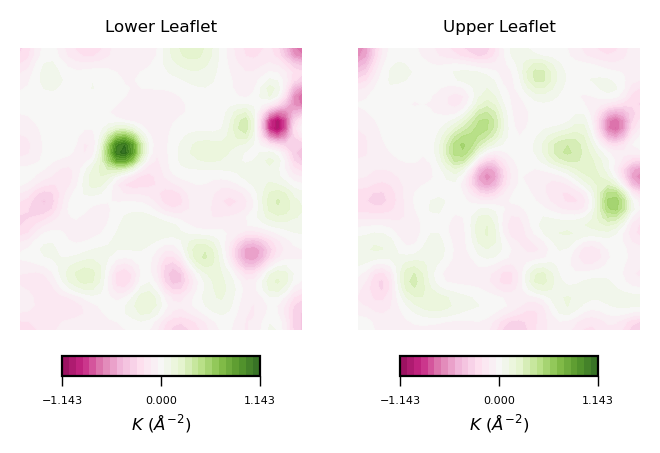

In [29]:
plot_contours(gaussian_curvs, "$K$ ($\AA^{-2}$)", 30, "PiYG")

To read plots of Gaussian curvature a rule of thumb is: negative Gaussian curvature represents saddles, positive Gaussian curvature represents concave regions. Generally speaking, Gaussian curvature is associated to the elasticity of the membrane.

From the obtained contour plot of Gaussian curvature, we can identify:

* Regions of positive Gaussian curvature (coloured in green) dominate in both leaflets.
* Overall, the membrane display concave regions (green coloured regions). In particular in the lower leaflet, we can identify a spot with the highest values of $K$. This can be translated to high flexibility of the membrane during the simulation.  

### Imshow

As an alternative, we can also plot results from MembraneCurvature via [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html). By using imshow, the visualization is generated by plotting each element of the array in a matrix of `m x n` elements and according to a colormap of reference. In the case of MembraneCurvature, the matrix has the same shape as the arrays stored in the `.results` attributes. So it will be a matrix of `n_x_bins, n_y_bins`. The color of each square is determined by the value of the corresponding array element and the color map used. 

The most basic plot using `imshow` to plot the surface in the lower leaflet can be obtained by:

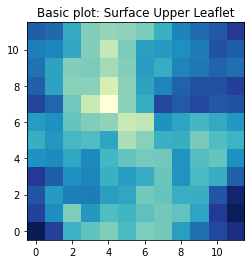

In [30]:
fig, ax = plt.subplots(1,1)
ax.imshow(surface_upper_leaflet[0], cmap='YlGnBu_r', origin='lower')
ax.set_aspect('equal')
ax.set_title('Basic plot: Surface Upper Leaflet')
plt.show()

The basic `imshow` plot to visualize the surface in the upper leaflet show a different color for each bin in the array. From this plot is very easy to identify we have 12 bins in each dimension.

This plot, however, is not visually pleasing. We can improve an `imshow` plot by adding an interpolation method. For consistency with the [**contour**](#Contours) plots, I am going to use the `'gaussian'` inteprolation method. For more inteprolation methods you can read the [imshow interpolation Matplotlib docs](https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html).

Hence, we can generate better `imshow` plots by doing something like:

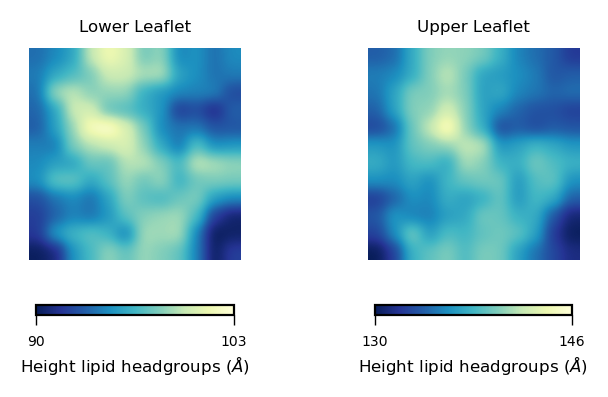

In [31]:
surfaces = [surface_lower_leaflet[0],  # surface in lower leaflet from frame=0 
            surface_upper_leaflet[0]]  # surface fn upper leaflet from frame=0


fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(4,2), dpi=200)
for ax, surfs, lf in zip((ax1, ax2), surfaces, leaflets):
    im = ax.imshow(surfs, interpolation='gaussian', cmap='YlGnBu_r', origin='lower')
    ax.set_aspect('equal')
    ax.set_title('{} Leaflet'.format(lf), fontsize=6)
    ax.axis('off')
    cbar = plt.colorbar(im, ticks=[surfs.min(), surfs.max()], orientation='horizontal', ax=ax, shrink=0.7)
    cbar.set_ticklabels([int(surfs.min()), int(surfs.max())])
    cbar.ax.tick_params(labelsize=5, width=0.5)
    cbar.set_label("Height lipid headgroups (${\AA}$)", fontsize=6, labelpad=2) 

In this plot we can see the height of the lipid headgroups in the lower (left panel) and upper leaflet (right panel). The colormap allows us to identify the heighest values of the lipid headgroups, coloured in yellow. The lowest values are shown in blue.

From these plots, we can identify a "bump" in the middle region of the membrane (yellow coloured), which is reduced progressively towards the edges of the simulation box.   

#### Visualizing multiframe results

We can take advantage of the the multiframe analysis extracted for the membrane surfaces performed in [section 4.1](#4.1-Surface) to visualize how the surface of our membrane changes over frames:

In [32]:
def plot_over_frames(surfaces, lf, label, cmap):

    fig, axs = plt.subplots(ncols=10, figsize=(8,4), dpi=300)
    for ax, surfs, frame in zip(axs, surfaces, range(universe.trajectory.n_frames)):
        im = ax.imshow(surfaces[frame], interpolation='gaussian', 
                       cmap=cmap, origin='lower', 
                       vmin=surfaces.min(), vmax=surfaces.max())
        ax.set_aspect('equal')
        ax.set_title('frame={}'.format(frame), fontsize=6)
        ax.axis('off')
    cbar = plt.colorbar(im, ticks=[surfs.min(), surfs.max()], 
                        orientation='vertical', ax=axs, shrink=0.2, 
                        aspect=15, pad=0.01)
    cbar.set_ticklabels([int(surfs.min()), int(surfs.max())])
    cbar.ax.tick_params(labelsize=5, width=0.5)
    cbar.set_label(label, fontsize=3, labelpad=2) 

Then, we can get the plots of the derived surface in the upper leaflet, over the 11 frames of the trajectory by:

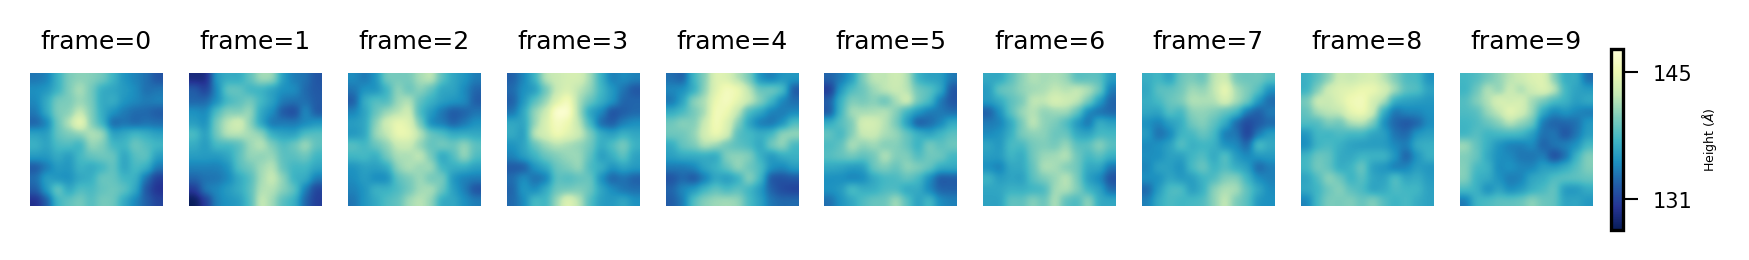

In [33]:
plot_over_frames(surface_upper_leaflet, # surfaces by frame
                 'Upper',               # Leaflet name
                 "Height (${\AA}$)",    # Colorbar label
                 'YlGnBu_r')              # cmap  

And for the lower leaflet:

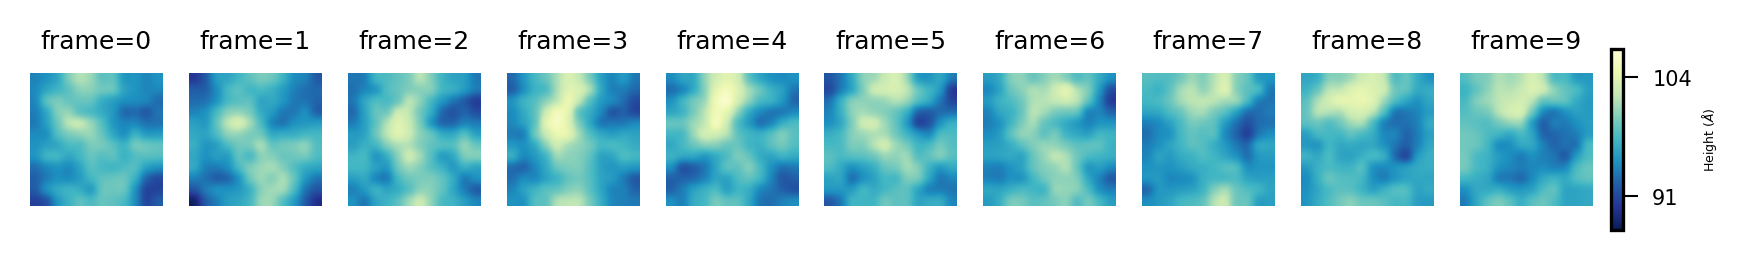

In [34]:
plot_over_frames(surface_lower_leaflet , 
                 'Lower', 
                 "Height (${\AA}$)", 
                 'YlGnBu_r')

To plot curvature using `imshow`, we can define a function to plot each leaflet based on this plot:

In [35]:
def plot_by_leaflet(results, label, cmap):
    fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(4,2), dpi=200)
    max_ = np.max(abs(results[0]))
    max_
    for ax, rs, lf in zip((ax1, ax2), results, leaflets):
        rs = ndimage.zoom(rs, 3, mode='wrap', order=2)
        im = ax.imshow(rs, interpolation='gaussian', cmap=cmap, origin='lower', alpha=0.95, vmin=-max_, vmax=max_)
        ax.set_title('{} Leaflet'.format(lf), fontsize=6)
        ax.axis('off') 
        
        cbar = plt.colorbar(im, ticks=[-max_, max_], 
                        orientation='horizontal', ax=ax, shrink=0.7, 
                        aspect=15)
        cbar.ax.tick_params(labelsize=5, width=0.5)
        cbar.set_label(label, fontsize=6, labelpad=2) 
        
    return




Then, using a similar approach as for the `results.z_surface`, and using our handy function `plot_by_leaflet`, we can plot the mean curvature associated to each leaflet

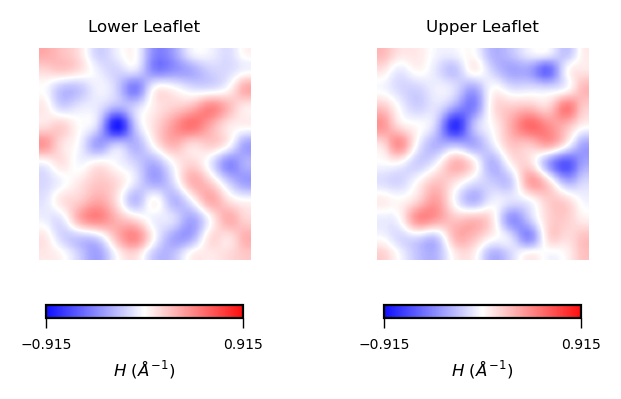

In [36]:
mean_curvs = [mean_lower_leaflet, mean_upper_leaflet]

plot_by_leaflet(mean_curvs, "$H$ ($\AA^{-1}$)", "bwr")

With the stored variables `gaussian_upper_leaflet` and `mean_upper_leaflet`, we can plot the results for the Gaussian curvature ($K$) using the function `plot_by_leaflet`.

In [37]:
gaussian_curvs = [gaussian_lower_leaflet, gaussian_upper_leaflet]

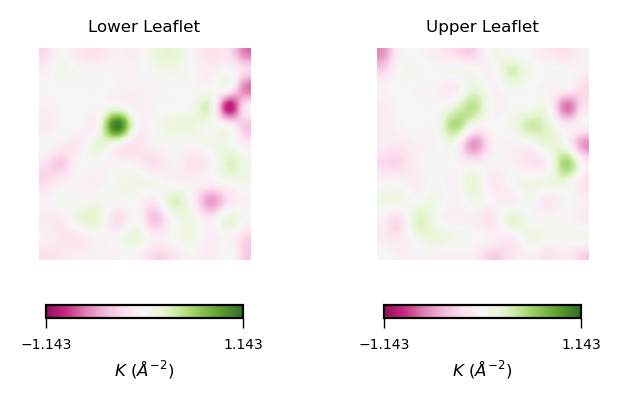

In [38]:
plot_by_leaflet(gaussian_curvs, "$K$ ($\AA^{-2}$)", "PiYG")

Et voilá :)